**Online Learning with Feedback Graphs: Beyond Bandits**

*Noga Alon, Nicolò Cesa-Bianchi, Ofer Dekel, Tomer Koren*

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class graph(object):
    
    def __init__(self, n_states):
        self.n_states = n_states
        self.neighbors = set()
        self.loss_p = np.random.uniform(0, 1, self.n_states) # np.ones(self.n_states)*0.5
        self.loss = None
        self.min_loss = None
        self.n_out = {i: set() for i in range(self.n_states)}
        self.n_in = {i: set() for i in range(self.n_states)}
        self.delta = None
        
    def add(self, i, j):
        self.neighbors.add((i, j))
        self.n_out[i].add(j)
        self.n_in[j].add(i)
        
    def show(self, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

        # create networkx graph
        G=nx.Graph()
        
        graph = list(self.neighbors)
        
        # add edges
        for edge in graph:
            G.add_edge(edge[0], edge[1])

        # these are different layouts for the network you may try
        # shell seems to work best
        if graph_layout == 'spring':
            graph_pos=nx.spring_layout(G)
        elif graph_layout == 'spectral':
            graph_pos=nx.spectral_layout(G)
        elif graph_layout == 'random':
            graph_pos=nx.random_layout(G)
        else:
            graph_pos=nx.shell_layout(G)

        # draw graph
        nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                               alpha=node_alpha, node_color=node_color)
        nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                               alpha=edge_alpha,edge_color=edge_color)
        nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                                font_family=text_font)

        if labels is None:
            labels = range(len(graph))

        #edge_labels = dict(zip(graph, labels))
        #nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
        #                             label_pos=edge_text_pos)

        # show graph
        plt.show()
        
    def get_loss(self, i, t):
        return self.loss[i, t]
    
    def generate_loss(self, n_iter):
        loss = []
        for i in range(self.n_states):
            loss.append(np.random.binomial(1, self.loss_p[i], n_iter))
        self.loss = np.vstack(loss)
    
    def compute_min_loss(self, n_iter):
        min_loss = []
        for t in range(n_iter):
            min_loss.append(np.min(np.sum(self.loss[:, :t+1], axis=1)))
        self.min_loss = np.array(min_loss)

In [3]:
def exp3(graph, learn_rate, gamma, n_iter=1000, exploration_set=None):
    graph.generate_loss(n_iter)
    graph.compute_min_loss(n_iter)
    loss = []
    loss_estimator = np.zeros(graph.n_states)
    q = np.ones(graph.n_states) / graph.n_states
    if exploration_set is None:
        u = np.ones(graph.n_states) / graph.n_states
    else:
        u = np.zeros(graph.n_states)
        for i in exploration_set:
            u[i] = 1 / len(u)
    for i in range(n_iter):
        p = (1 - gamma) * q + gamma * u
        p = p / np.linalg.norm(p, ord=1)
        choice = np.random.choice(graph.n_states, 1, p=p)[0]
        loss.append(graph.get_loss(choice, i))
        loss_estimator = np.array([graph.get_loss(k, i) / np.sum(p[list(graph.n_in[k])]) if k in graph.n_out[choice] else 0 for k in range(graph.n_states)])
        q = q * np.exp(-learn_rate * loss_estimator)
        q = q / np.linalg.norm(q, ord=1)
    regret = np.cumsum(np.array(loss)) - graph.min_loss
    return q, regret

In [4]:
n_states = 5

a = graph(n_states)
for i in range(n_states):
    for j in range(n_states):
        a.add(i,j)
a_dom = [0]

b = graph(n_states)
for i in range(n_states):
    b.add(i,i)
b_dom = [i for i in range(n_states)]
b.delta = n_states

c = graph(n_states)
for i in range(n_states):
    for j in range(n_states):
        if i != j:
            c.add(i,j)
c_dom = [0, 1]

e = graph(n_states)
for i in range(n_states):
    e.add(0, i)
e_dom = [0]
e.delta = 1

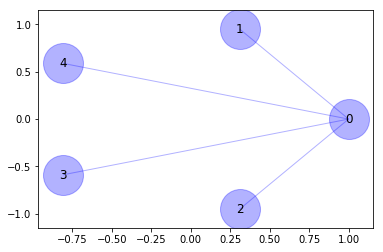

In [121]:
e.show()

### Regret sur différents graphs sans l'exploration set

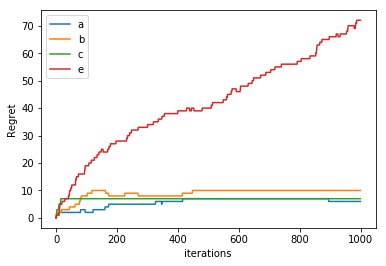

In [18]:
n_iter = 1000

graphs = [a, b, c, e]
names = ['a', 'b', 'c', 'e']
regrets = []

for graph_ in graphs:
    q, regret = exp3(graph_, learn_rate=0.2, gamma=0., n_iter=n_iter)
    regrets.append(regret)

x = np.arange(n_iter)
plt.plot(x, regrets[0], x, regrets[1], x, regrets[2], x, regrets[3])
plt.legend(names)
plt.xlabel('iterations')
plt.ylabel('Regret')
plt.show()

### Impact de l'exploration set

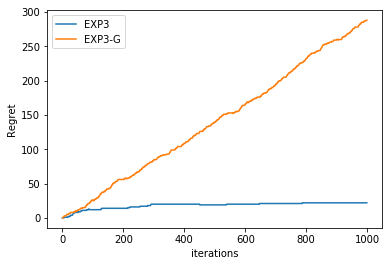

In [24]:
n_iter = 1000

gamma = min(1/2, 1/(b.n_states * n_iter)**2)
learn_rate = gamma / 2

q, regret1 = exp3(b, learn_rate=0.1, gamma=0., n_iter=n_iter)
q, regret2 = exp3(b, learn_rate=learn_rate, gamma=gamma, n_iter=n_iter)

x = np.arange(n_iter)
plt.plot(x, regret1, x, regret2)
plt.legend(['EXP3', 'EXP3-G'])
plt.xlabel('iterations')
plt.ylabel('Regret')
plt.show()

### Comportement asymptotique du regret pour un weakly observable graph

In [103]:
def exp3_doubling_trick(graph, learn_rate, gamma, n_iter=1000, exploration_set=None):
    graph.generate_loss(n_iter)
    graph.compute_min_loss(n_iter)
    loss = []
    loss_estimator = np.zeros(graph.n_states)
    q = np.ones(graph.n_states) / graph.n_states
    if exploration_set is None:
        u = np.ones(graph.n_states) / graph.n_states
    else:
        u = np.zeros(graph.n_states)
        for i in exploration_set:
            u[i] = 1 / len(u)
    for i in range(n_iter):
        if (i & (i - 1)) == 0 and i > graph.n_states**3 * np.log(graph.n_states) / graph.delta**2:
            gamma = min(1/2, (graph.delta * np.log(graph.n_states) / i)**(1/3))
            learn_rate = gamma**2 / graph.delta
        p = (1 - gamma) * q + gamma * u
        p = p / np.linalg.norm(p, ord=1)
        choice = np.random.choice(graph.n_states, 1, p=p)[0]
        loss.append(graph.get_loss(choice, i))
        loss_estimator = np.array([graph.get_loss(k, i) / np.sum(p[list(graph.n_in[k])]) if k in graph.n_out[choice] else 0 for k in range(graph.n_states)])
        q = q * np.exp(-learn_rate * loss_estimator)
        q = q / np.linalg.norm(q, ord=1)
    regret = np.cumsum(np.array(loss)) - graph.min_loss
    return q, regret

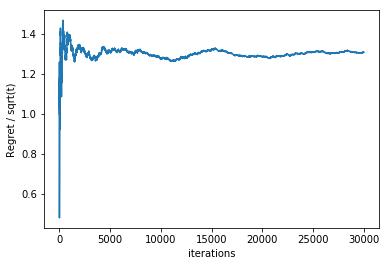

In [105]:
n_iter = 30000

q, regret = exp3_doubling_trick(b, learn_rate=0.1, gamma=0.5, n_iter=n_iter, exploration_set=b_dom)

x = np.arange(n_iter)
t = np.array([i**(2/3) for i in range(1, n_iter+1)])
plt.plot(x, regret/t)
plt.xlabel('iterations')
plt.ylabel('Regret / sqrt(t)')
plt.show()